In [195]:
#import jhu
import pandas as pd
import covid.util as util
print ("tmp")

tmp


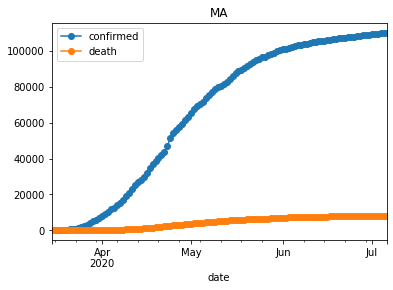

In [196]:
import matplotlib.pyplot as plt
US = util.jhu.load_us()
start = pd.Timestamp('2020-03-15')

US[0]['MA'][start:].plot(style='o-')
plt.title('MA')
plt.show()
vals = US[0]['MA'][start:]['death'].values

In [197]:
import jax
import jax.numpy as np
from jax.random import PRNGKey

import numpyro
import numpyro.distributions as dist

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
from jax import random, vmap

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

num_warmup, num_samples = 1000, 2000

#

import numpy as onp

def kernel(X, Z, var, length, noise, jitter=1.0e-6, include_noise=True):
    deltaXsq = np.power((X[:, None] - Z) / length, 2.0)
    k = var * np.exp(-0.5 * deltaXsq)
    if include_noise:
        k += (noise + jitter) * np.eye(X.shape[0])
    return k


def model(vals=None,t_future=0):
    rng_key, rng_key_predict = random.split(random.PRNGKey(0))

    var = numpyro.sample("kernel_var", dist.LogNormal(0.0, 10.0))
    noise = numpyro.sample("kernel_noise", dist.LogNormal(0.0, 10.0))
    length = numpyro.sample("kernel_length", dist.LogNormal(0.0, 10.0))
    X = np.arange(len(vals))
    # compute kernel
    k = kernel(X, X, var, length, noise)

    # sample Y according to the standard gaussian process formula
    rw=numpyro.sample("rw", dist.MultivariateNormal(loc=np.zeros(X.shape[0]), covariance_matrix=k))
   # rw = numpyro.sample("rw",dist.GaussianRandomWalk(scale=10, num_steps=len(vals)))
    d0 = numpyro.sample("d0",dist.Normal(vals[0],100))
    i_mean = np.cumsum(rw)+d0
    
    numpyro.sample('obs', dist.Normal(i_mean, 1), obs=np.log(vals+1e-20))
    if (t_future >0):
        X_test = np.arange(len(vals),len(vals)+t_future)
        k_pp = kernel(X_test, X_test, var, length, noise, include_noise=True)
        k_pX = kernel(X_test, X, var, length, noise, include_noise=False)
        k_XX = kernel(X, X, var, length, noise, include_noise=True)
        K_xx_inv = np.linalg.inv(k_XX)
        K = k_pp - np.matmul(k_pX, np.matmul(K_xx_inv, np.transpose(k_pX)))
        sigma_noise = np.sqrt(np.clip(np.diag(K), a_min=0.)) * jax.random.normal(rng_key, X_test.shape[:1])
        mean = np.matmul(k_pX, np.matmul(K_xx_inv, rw))
        i_mean_future = np.cumsum(mean) + i_mean[-1]
        print (X_test)
        
        numpyro.sample('obs_future', dist.Normal(i_mean_future , .00001))
        

kern = NUTS(model)
mcmc = MCMC(kern, num_warmup, num_samples)
mcmc.run(rng_key_, vals=vals[1:100])
mcmc.print_summary()
samples_1 = mcmc.get_samples()
    
    

sample: 100%|██████████| 3000/3000 [18:12<00:00,  2.75it/s, 511 steps of size 9.88e-03. acc. prob=0.93]  



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
             d0    -46.06      4.59    -46.02    -53.75    -38.95   3065.79      1.00
  kernel_length 793350111232.00 30521090375680.00      0.04      0.00  11621.97   2002.31      1.00
   kernel_noise     13.49      9.40     17.57      0.00     23.13    558.86      1.01
     kernel_var      8.64     30.02      0.36      0.00     21.47   1833.37      1.00
          rw[0]      0.04      4.48     -0.02     -6.87      7.53   3060.51      1.00
          rw[1]     -0.03      1.35     -0.04     -2.28      2.10   3592.60      1.00
          rw[2]      0.08      1.32      0.09     -2.19      2.15   3117.66      1.00
          rw[3]      1.94      1.30      1.94     -0.09      4.15   3031.79      1.00
          rw[4]     42.00      1.39     42.00     39.73     44.23   3358.50      1.00
          rw[5]      2.00      1.34      1.99     -0.15      4.17   4191.33      1.00
          rw[6]      1.61      1.32    

In [192]:
from numpyro.infer import Predictive

rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model, samples_1)
predictions = predictive(rng_key_, vals=vals[1:100],t_future=20)

[ 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118]


In [193]:
print (predictions)
predictions_obs = predictions['obs']
predictions_obs_future = predictions['obs_future']

{'obs': DeviceArray([[-11.512925, -11.512925, -11.512925, ...,   8.965463,
                8.969288,   8.971321],
             [-11.512925, -11.512925, -11.512925, ...,   8.965463,
                8.969288,   8.971321],
             [-11.512925, -11.512925, -11.512925, ...,   8.965463,
                8.969288,   8.971321],
             ...,
             [-11.512925, -11.512925, -11.512925, ...,   8.965463,
                8.969288,   8.971321],
             [-11.512925, -11.512925, -11.512925, ...,   8.965463,
                8.969288,   8.971321],
             [-11.512925, -11.512925, -11.512925, ...,   8.965463,
                8.969288,   8.971321]], dtype=float32), 'obs_future': DeviceArray([[ 8.548004 ,  8.571454 ,  8.627933 , ..., 10.6055765,
              10.651223 , 10.6861725],
             [ 8.601685 ,  8.624004 ,  8.669107 , ...,  9.861    ,
               9.88931  ,  9.911579 ],
             [ 8.90532  ,  8.835819 ,  8.782214 , ...,  9.203951 ,
               9.213267 ,  9

[[ 8.548004   8.571454   8.627933  ... 10.6055765 10.651223  10.6861725]
 [ 8.601685   8.624004   8.669107  ...  9.861      9.88931    9.911579 ]
 [ 8.90532    8.835819   8.782214  ...  9.203951   9.213267   9.219604 ]
 ...
 [ 8.918959   8.78936    8.618949  ...  6.987887   6.9848514  6.983193 ]
 [ 8.986295   8.945587   8.963113  ... 10.79212   10.803182  10.809869 ]
 [ 7.871984   7.2880535  6.634233  ...  2.553453   2.5498924  2.5480838]]
(99,)


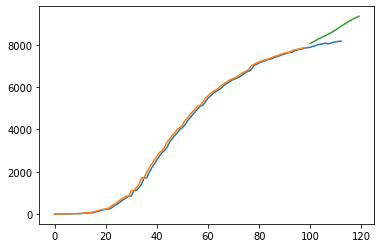

In [194]:
print (predictions_obs_future)
#plt.plot(samples_1['rw'])
#plt.plot(np.mean(np.exp(predictions),axis=0))
print (samples_1['rw'][samp,:].shape)
#for samp in range(1000):
#    plt.plot(np.exp(np.cumsum(samples_1['rw'][samp,:]) + samples_1['d0'][samp]),alpha=.1)
plt.plot(range(len(vals)),vals)
plt.plot(range(99),np.exp(np.mean(predictions_obs,axis=0)))
plt.plot(range(100,120),np.exp(np.mean(predictions_obs_future,axis=0)))

plt.show()